# Preliminaries

In [ ]:
import subprocess

In [ ]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/plausibilities/sars/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

## Paths

In [3]:
import os
import pathlib
import sys

In [4]:
if not 'google.colab' in str(get_ipython()):
    
    notebooks = os.path.split(os.getcwd())[0]
    parent = str(pathlib.Path(notebooks))
    sys.path.append(parent)


<br>

## Libraries

In [5]:
%matplotlib inline

In [6]:
import arviz as az
import graphviz
import dotmap
import pymc3 as pm

import logging

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import collections

<br>

**Custom**

In [7]:
import sars.graphics.settings
import sars.graphics.relational

In [8]:
import sars.capita.feed.data
import sars.capita.feed.segmentation

<br>

## Set-up

**Display**<br>
If the display screen supports **retina display**, a figure's resolution can be enhanced via


In [9]:
%config InlineBackend.figure_format = 'retina'

<br>

**Jupyter Settings**

In [10]:
settings = sars.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

**Relational Graph Labels**

In [11]:
RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

## Logging

In [12]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

<br>
<br>

# Data

## Read

In [13]:
data = sars.capita.feed.data.Data().read()
logger.info('\n{}\n'.format(data.head()))

INFO:__main__:
  datetimeobject STUSPS  deathRate  positiveRate  testRate  icuRate  \
0     2020-01-22     AK        0.0           0.0       0.0      0.0   
1     2020-01-23     AK        0.0           0.0       0.0      0.0   
2     2020-01-24     AK        0.0           0.0       0.0      0.0   
3     2020-01-25     AK        0.0           0.0       0.0      0.0   
4     2020-01-26     AK        0.0           0.0       0.0      0.0   

   hospitalizedRate  ndays  
0               0.0      0  
1               0.0      1  
2               0.0      2  
3               0.0      3  
4               0.0      4  



<br>

**In Focus**

In [14]:
stusps = 'ND'

<br>

**Hence**

In [15]:
segmentation = sars.capita.feed.segmentation.Segmentation(data=data)

features, observations, frame = segmentation.exc(
    stusps=stusps, independent=['ndays'], dependent=['positiveRate', 'hospitalizedRate', 'deathRate'])

logger.info('The shape & type of features\n{}, {}\n'.format(features.shape, type(features)))
logger.info('The shape & type of observations\n{}, {}\n'.format(observations.shape, type(observations)))
logger.info('The frame\n{}, {}\n'.format(frame.shape, type(frame)))

INFO:__main__:The shape & type of features
(256, 1), <class 'numpy.ndarray'>

INFO:__main__:The shape & type of observations
(256, 3), <class 'numpy.ndarray'>

INFO:__main__:The frame
(256, 4), <class 'pandas.core.frame.DataFrame'>



<br>

An illustration of the independent & dependent variables

In [16]:
import sars.capita.models.covariates.graphs

In [17]:
graphs = sars.capita.models.covariates.graphs.Graphs()

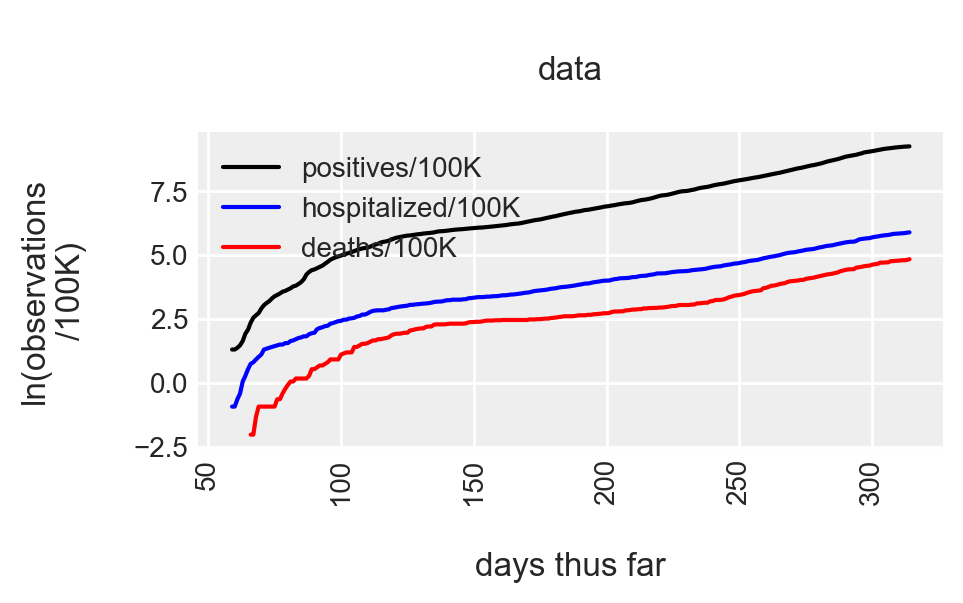

In [18]:
ax = graphs.baseline(
    data=frame, labels=RelationalGraphLabels._make(['\ndata\n', '\ndays thus far', 'ln(observations\n/100K)\n'])
)
ax.legend(loc='upper left', fontsize='small');

<br>
<br>

# Inference

## Structures

Preparing dat structures for the inference model

* Normalize $\rightarrow$ Create Theano/Shared form of normalized structure


In [19]:
import sars.capita.models.covariates.structures

In [20]:
structures = sars.capita.models.covariates.structures.Structures(dependents=observations.shape[1])

<br>

**Scaling Objects & Structures** of the:

* Independent Variable/s

In [21]:
XSCALER, XSC, XTH = structures.exc(tensor=features, predictor=True)

logger.info('\nThe shape & type of the scaled features: {}, {}.\nThe type of the shared/Theano form of the scaled features: {} \n'.
       format(XSC.shape, type(XSC), type(XTH)))


INFO:__main__:
The shape & type of the scaled features: (256, 1), <class 'numpy.ndarray'>.
The type of the shared/Theano form of the scaled features: <class 'theano.tensor.sharedvar.TensorSharedVariable'> 



<br>

* Dependent Variable/s

In [22]:
YSCALER, YSC, YTH = structures.exc(tensor=observations, predictor=False)

logger.info('\nThe shape & type of the scaled observations: {}, {}.\nThe type of the shared/Theano form of the scaled observations: {} \n'.
       format(YSC.shape, type(YSC), type(YTH)))


INFO:__main__:
The shape & type of the scaled observations: (256, 3), <class 'numpy.ndarray'>.
The type of the shared/Theano form of the scaled observations: <class 'theano.tensor.sharedvar.TensorSharedVariable'> 



<br>

## Futures

In [23]:
futures = segmentation.futures(features=features, steps=np.array([1]), ahead=25)

logger.info('The shape of futures\n{}\n'.format(futures.shape))

INFO:__main__:The shape of futures
(281, 1)

